### Bibliotecas

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import statsmodels.api as sm 
import yfinance as yf 
from datetime import datetime, timedelta
import pylab
from scipy import stats

### Base de Dados

In [137]:
#Extraíndo a base de dados com o Yahoo Finance

data_final = '2023-12-31'

tickers = ['PBR', 'BZ=F'] # Cotação da Petrobras e do Petróleo Brent em dólares respectivamente
dados = pd.DataFrame()

for t in tickers:
    dados[t] = yf.download(t, end=data_final, progress=False)['Adj Close']

In [138]:
#Ajustando a frequência de dados para trimestral (quaterly) e removando os NaN

dados = (dados.resample('Q').mean()).dropna()

#Alterando o nome das colunas

dados.rename(columns={'PBR': 'Petrobras', 'BZ=F': 'Brent Oil'}, inplace=True)

dados

,Petrobras,Brent Oil
Date,,
2007-09-30,10.126464,74.029773
2007-12-31,15.243300,88.401094
2008-03-31,17.445340,96.449016
2008-06-30,20.680426,122.675000
2008-09-30,16.466755,116.889219
...,...,...
2022-12-31,8.928708,88.683175
2023-03-31,8.659670,82.032580
2023-06-30,10.587410,77.763871


### Retorno Acumulado

<Axes: xlabel='Date'>

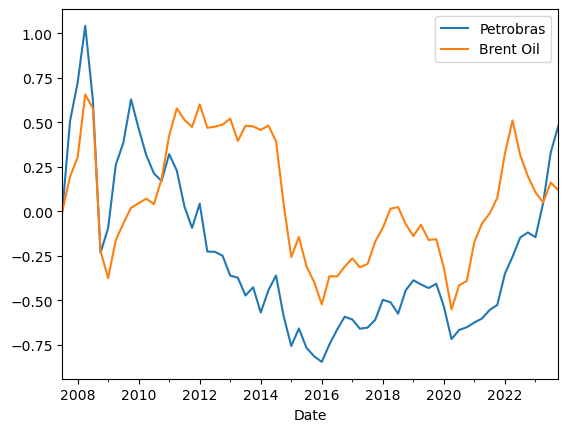

In [139]:
retorno_acumulado = dados/dados.iloc[0]-1
retorno_acumulado.plot()

### Retorno Aritmético

<Axes: xlabel='Date'>

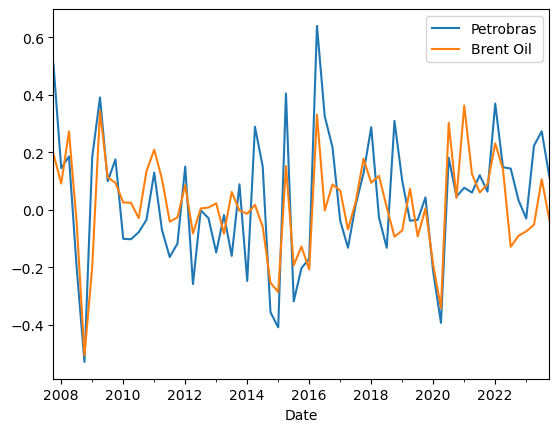

In [140]:
retorno_aritmetico = (dados/dados.shift(1)-1).dropna()
retorno_aritmetico.plot()

### Transformação logaritimica

<Axes: xlabel='Date'>

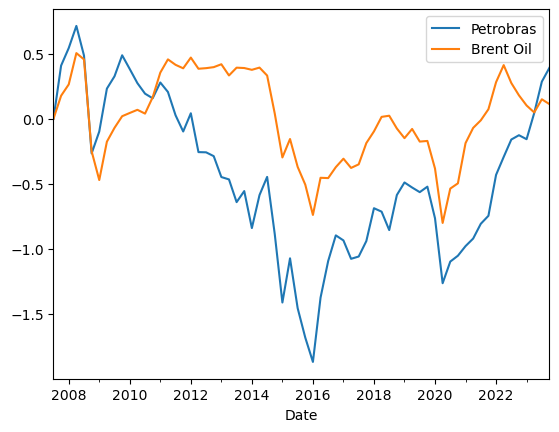

In [141]:
log_retorno_acumulado = np.log(dados/dados.iloc[0])
log_retorno_acumulado.plot()

<Axes: xlabel='Date'>

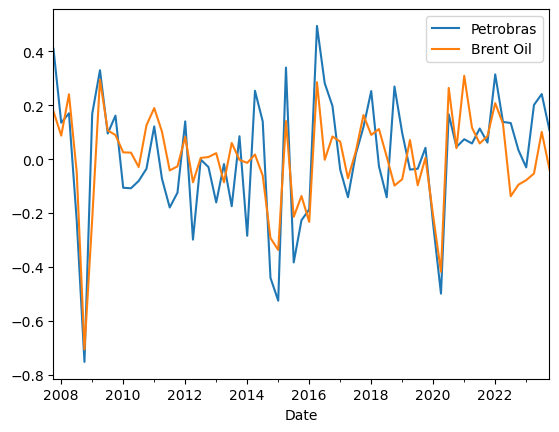

In [142]:
log_retorno_aritmetico = (np.log(dados/dados.shift(1))).dropna()
log_retorno_aritmetico.plot()

Uma propriedade interessante dos log retornos é que a soma do retornos periódicos é igual ao retorno acumulado do respectivo período. 

In [179]:
print(round(sum(log_retorno_aritmetico['Petrobras']),4))
print(round(log_retorno_acumulado['Petrobras'].iloc[-1],4))

0.3931
0.3931


## Distribuição dos Dados

O gráfico de dispersão (scatter plot) fornece insights preliminares sobre a relação estatística entre as variáveis analisadas onde podemos vizualizar uma relação positiva entre variações do preço do petróleo Brent e das ações da Petrobras. Ao calcular o coeficiente de correlação, constatamos uma correlação serial positiva significativa de 75%.

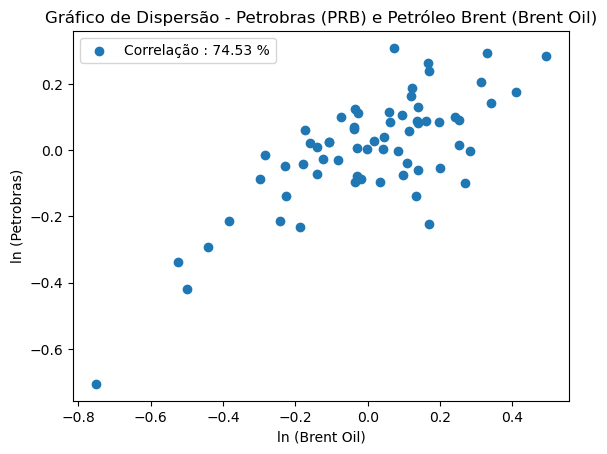

In [145]:
#Gráfico de Dispersão ou Scatter Plot

correlacao = log_retorno_aritmetico['Petrobras'].corr(log_retorno_aritmetico['Brent Oil'])

plt.scatter(log_retorno_aritmetico['Petrobras'], log_retorno_aritmetico['Brent Oil'], label = f"Correlação : {round(correlacao*100,2)} %")
plt.xlabel('ln (Brent Oil)')
plt.ylabel('ln (Petrobras)')
plt.title('Gráfico de Dispersão - Petrobras (PRB) e Petróleo Brent (Brent Oil)')
plt.legend()

# Regressão Linear Simples

A análise de regressão é uma técnica estatística que busca estudar a relação de dependência entre uma variável a ser explicada (dependente) e uma ou mais variáveis explanatórias (independentes). 

$
\large y_i = \beta_0 + \beta_1 x_i + \epsilon_i \\
$ 

$
y_i = \text{Variável dependente} \\[1pt]
x_i = \text{Variável independente} \\[1pt]
\beta_0 = \text{Constante} \\[1pt]
\beta_1 = \text{Coeficiente Angular} \\[1pt]
\varepsilon_i = \text{Erro ou Resíduo}
$

### Preparando os cálculos

In [146]:
#Estamos atribuindo à variável df a tabela de log retornos, df é o nome genérico para dataframe

df = log_retorno_aritmetico

# Atribuíndo qual variável será a dependente (explicada) e a independente (explicativa)
y = df['Petrobras']
x = df['Brent Oil']

df

,Petrobras,Brent Oil
Date,,
2007-12-31,0.408988,0.177417
2008-03-31,0.134932,0.087130
2008-06-30,0.170115,0.240524
2008-09-30,-0.227844,-0.048312
2008-12-31,-0.752106,-0.705654
...,...,...
2022-12-31,0.033036,-0.094616
2023-03-31,-0.030595,-0.077954
2023-06-30,0.200989,-0.053440


### Coeficiente Angular

Forma algébrica para o cálculo do coeficiente angular.

$
\beta_1 = \large \frac{{n \sum_{i=1}^{n} (Y_i \cdot X_i) - \sum_{i=1}^{n}(Y_i) \cdot \sum_{i=1}^{n}(X_i)}}{{n \sum_{i=1}^{n}(X_i^2) - \sum_{i=1}^{n}(X_i)^2}}
$

In [147]:
b = (len(df) * sum (y*x) - sum(y)*sum(x)) / (len(df) * sum(x**2) - sum(x)**2)
b

1.0070315223714643

### Constante

Forma algébrica para o cálculo da constante.

$
\beta_0 = \large \frac{{(\sum_{i=1}^{n}(Y_i) - \beta_1 \cdot \sum_{i=1}^{n}(X_i))}}{{n}}
$

In [148]:
a = (sum(y) - b * sum(x)) / len(df)
a

0.004298641883552693

### Previsão

Visto que já encontramos a nossa constante e o coeficiente angular, podemos então prever os valores de y^ a um dado valor de x, esse cálculo será importante pois conseguiremos analisar a qualidade da nossa regressão. 

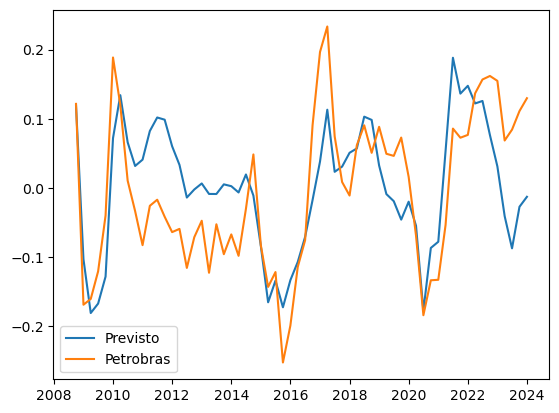

In [149]:
#Cálculo da previsão

df['Previsto'] = a + b * x

#Gráfico suavizado para médias móveis de 4 trimestres

plt.plot(df['Previsto'].rolling(4).mean(), label = 'Previsto')
plt.plot(y.rolling(4).mean(), label = 'Petrobras')
plt.legend()

### Resíduos

O resíduo é simplesmente a diferença do valor previsto (y^) em relação aos valores efetivamente observados da variável explicada ou dependente (y), intuitivamente representa os valores que não são explicados pelo modelo de regressão. A ideia de utilizar o MMQ (Método dos Mínimos Quadrados) é precisamente minimizar a soma do quadrado dos resíduos. 

Para verificar se o modelo utilizado foi apropriado é feito o que é chamado de análise de resíduos. No Estatística Básica do Bussab e Morettin (2005) sugere-se plotar em um gráfico de dispersão em relação a variável explicativa e no gráfico Q-Q para verificar se respeita a hipótese de normalidade. 

In [150]:
#Cálculo dos resíduos

df['Residuos'] = y - df['Previsto']
df['Residuos']

Date
2007-12-31    0.226025
2008-03-31    0.042891
2008-06-30   -0.076399
2008-09-30   -0.183491
2008-12-31   -0.045789
                ...   
2022-12-31    0.124018
2023-03-31    0.043608
2023-06-30    0.250506
2023-09-30    0.135208
2023-12-31    0.140649
Freq: Q-DEC, Name: Residuos, Length: 65, dtype: float64

Text(0.5, 1.0, 'Distribuição dos Resíduos')

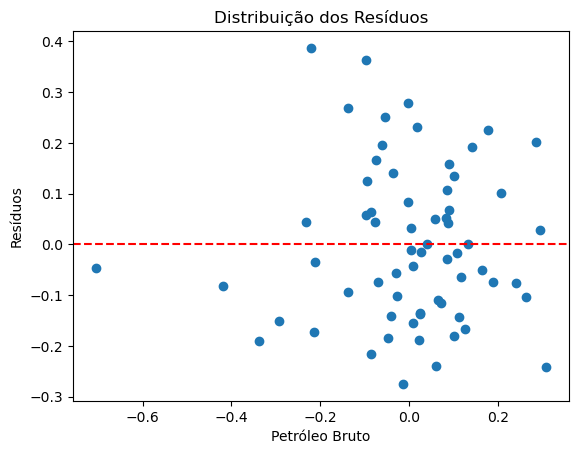

In [151]:
#Gráfico de Dispersão dos Resíduos

plt.scatter(x, df['Residuos'])
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Petróleo Bruto')
plt.ylabel('Resíduos')
plt.title('Distribuição dos Resíduos')

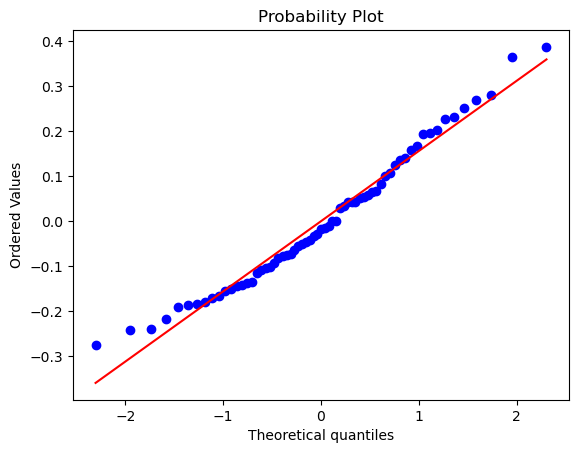

In [152]:
#Gráfico Q-Q

stats.probplot(df['Residuos'], dist="norm", fit =True, plot=pylab);

### Coeficiente de Determinação - R2

É uma medida estatística que mede o quanto a reta de regressão se ajusta aos valores observados da variável dependente (explicada). Um caso hipotético onde todos os valores da variável dependente estivessem sob a reta de regressão, neste caso não haveria resíduos (SQRes = 0) e o coeficiente de determinação r2 seria igual a 1 ou 100%. 

$
R^2 = 1 - \large \frac{SQRes}{SQTot}
$

In [153]:
#Soma dos Quadrados Totais
SQTot = sum((y-y.mean())**2)

#Soma dos Quadrados dos Resíduos
SQRes = sum(df['Residuos']**2)

#Cálculo do Coeficiente de Determinação
r2 = 1 - SQRes/SQTot
r2

0.5554911034517594

### Erro Padrão do Estimador

O erro padrão (ep) dos estimadores é utilizado para medir a sua confiabilidade, quanto menor o seu erro padrão menor seria a probabilidade de ter obtido um estimador diferente do valor verdadeiro da população.

$ ep(\hat{\beta}_1) = \large \sqrt{\frac{\sum_{i=1}^{n} \varepsilon_i^2}{(n-2) \sum_{i=1}^{n} (x_i - \bar{x})^2}} $

$ ep(\hat{\beta}_0) = ep(\hat{\beta}_1) \cdot \sqrt{\frac{1}{n} \sum_{i=1}^{n} x_i^2} $

In [154]:
#Calculo do erro padrão do coeficiente angular

sb = (sum(df['Residuos']**2)) / ((len(df)-2) * sum((x-x.mean())**2))**0.5
round(sb,3)

0.14

In [155]:
#Calculo do erro padrão da constante

sa = sb * ((1/len(df))*sum(x**2))**(0.5)
round(sa,3)

0.024

### Teste T

O teste t é um teste estatístico utilizado quando a variância da população é desconhecida. Calcula-se o teste t para os coeficientes estimados e verifica-se se os valores encontrados estão dentro ou fora do intervalo de confiança. Na prática, quando o t é "grande", rejeitamos a hipótese nula. 

$
t = \large \frac {\hat{\beta_i}}{ep(\hat{\beta_i})}\\[20pt]
$

$ 
\beta_i = \text{Estimador} \\[0pt]
ep(\hat{\beta_i}) = \text{Desvio (Erro) Padrão do Estimador}
$

Distribuição t de Student: https://pt.wikipedia.org/wiki/Distribui%C3%A7%C3%A3o_t_de_Student

Teste t de Student: https://pt.wikipedia.org/wiki/Teste_t_de_Student

In [156]:
t_angular = b/sb
round(t_angular,3)

7.18

In [157]:
t_constante = a/sa
round(t_constante,3)

0.18

### Intervalo de Confiança

A interpretação dos intervalos de confiança é a seguinte: ao assumir um nível de confiança de α = 5% pode-se dizer que 95% dos valores estão dentro do intervalo de confiança. Basta comparar o valor encontrado no teste t e ver se ele se encontra dentro ou fora do intervalo de confiança, caso ele esteja fora deste intervalo de confiança então podemos rejeitar a hipótese nula de que o estimador é diferente de 0 com 5% de nível de confiança e aceitar a hipótese alternativa de que ele é diferente de zero. 

$
\hat{\beta_i} \pm t_{\alpha / 2} \cdot {ep(\hat{\beta_i})} \\[10pt]
$

$ 
\beta_i = \text{Estimador} \\
t = \text{Valor Crítico de }t\\
\alpha = \text{Nível de Significância}\\
ep(\hat{\beta_i}) = \text{Desvio (Erro) Padrão do Estimador}
$

Segundo Gujarati, "na linguagem dos testes de significância, uma estatística é dita significativa se o valor do teste estatístico situar-se na região crítica. Neste caso, a hipótese nula é rejeitada.".

$
H_0: \hat{\beta_2} = 0 \\
H_1: \hat{\beta_2} \neq 0
$

Uma hipótese muito importante de ser testada é que $ H_0: \hat{\beta_i} = 0 $, ou seja, que o coeficiente angular estimado tem alguma relação significativa com a variável dependente $Y$.

In [158]:
from scipy.stats import t

# Graus de Liberdade
num_coef = 2
tamanho_amostra = len(df)
graus_de_liberdade = tamanho_amostra - num_coef

nivel_significancia = 0.05

t_critico = t.ppf(1 - nivel_significancia/2, graus_de_liberdade)
t_critico

1.9983405417721956

In [159]:
ic_angular = b * t_critico * sb
print(f"O intervalo de confiança do coeficiente angular está entre {round((b-ic_angular),3)} e {round((b+ic_angular),3)} com {nivel_significancia*100} % de nível de significância.")

O intervalo de confiança do coeficiente angular está entre 0.725 e 1.289 com 5.0 % de nível de significância.


### Estatística F

$
F = \large \frac{r^2 \cdot (k - 1)} {(1 - r^2) \cdot (n - k)}
$

In [160]:
F = (r2 / (num_coef-1))/((1-r2)/(tamanho_amostra-num_coef))
round(F,3)

78.729

### Tabela Final de Dados

In [164]:
df

,Petrobras,Brent Oil,Previsto,Residuos
Date,,,,
2007-12-31,0.408988,0.177417,0.182963,0.226025
2008-03-31,0.134932,0.087130,0.092041,0.042891
2008-06-30,0.170115,0.240524,0.246514,-0.076399
2008-09-30,-0.227844,-0.048312,-0.044353,-0.183491
2008-12-31,-0.752106,-0.705654,-0.706317,-0.045789
...,...,...,...,...
2022-12-31,0.033036,-0.094616,-0.090982,0.124018
2023-03-31,-0.030595,-0.077954,-0.074203,0.043608
2023-06-30,0.200989,-0.053440,-0.049517,0.250506


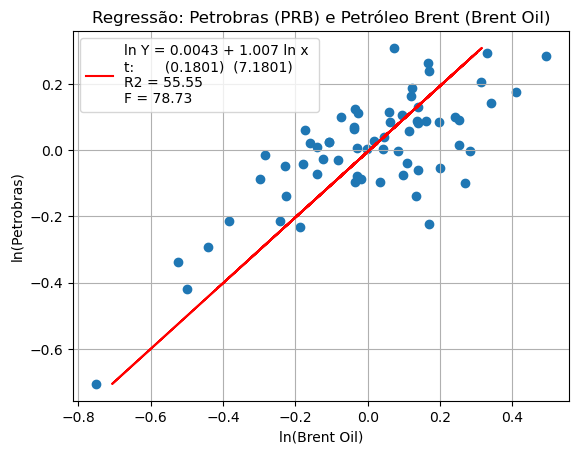

In [175]:
plt.scatter(y, x)
plt.plot(df['Previsto'], x, color = 'red', label = f"ln Y = {round(a,4)} + {round(b,4)} ln x \nt:       ({round(t_constante,4)})  ({round(t_angular,4)}) \nR2 = {round(r2*100,2)}\nF = {round(F,2)}")
plt.xlabel('ln(Brent Oil)')
plt.ylabel('ln(Petrobras)')
plt.title("Regressão: Petrobras (PRB) e Petróleo Brent (Brent Oil)")
plt.grid()
plt.legend()

### Validação dos Dados com Statsmodels

Podemos agora comparar os resultados calculados manualmente com que obteríamos utilizando uma biblioteca como a statmodels.

In [166]:
X = sm.add_constant(x)
modelo = sm.OLS(y, X)
resultados = modelo.fit()
resultados.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Petrobras   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     78.73
Date:                Tue, 09 Jan 2024   Prob (F-statistic):           1.07e-12
Time:                        17:49:58   Log-Likelihood:                 29.676
No. Observations:                  65   AIC:                            -55.35
Df Residuals:                      63   BIC:                            -51.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.019      0.223      0.825      -0.034       0.043
Brent Oil      1.0070      0.113      8.873      0.000       0.780       1.234
==============================================================================
Omnibus:                        2.976   Durbin-Watson:                   1.763
Prob(Omnibus):                  0.226   Jarque-Bera (JB):                2.893
Skew:                           0.470   Prob(JB):                        0.235
Kurtosis:                       2.572   Cond. No.                         5.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""